## 1. Collect Basic Data

### Retrieve CryptoCurrency Market Data ###

In [1]:
import pandas as pd
import yfinance as yf
from functools import reduce
import requests
import time
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


CRYPTO = False

# Crypto Details
cryptoProducts = ["ETH-USD", "USDT-USD", "BTC-USD"]
availableGranularities = dict(zip(["1M", "5M", "15M", "1H", "6H", "1D"], [60, 300, 900, 3600, 21600, 86400]))

# Stock Details
dowTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "ULVR.L"]  
period = "1D"
indexProducts = dowTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

if CRYPTO:
    productIds = cryptoProducts
    period = "6H"
    granularity = availableGranularities[period]
    API_THRESHOLD = 300 #Can only get 300 periods at a time from API
    PERIODS_WANTED = 2500

# not a chance
def retrieveCryptoData(productID, granularity, daysBack, endTime):
    API_URL = f"https://api.exchange.coinbase.com/products/{productID}/candles"
    daysBackDaysAgo = timedelta(days=daysBack)
    startTime = datetime.fromisoformat(endTime) - (granularity/86400) * daysBackDaysAgo

    # Convert to isoformat
    startTime = startTime.isoformat()

    # Set Request Parameters
    parameters = {
        "start" : startTime,
        "end" : endTime,
        "granularity" : str(granularity)
    }

    # Actually get data
    data = requests.get(API_URL, params = parameters, headers = {"content-type":"application/json"})
    df = pd.DataFrame(data.json(), columns=["time", "low", "high", "open", "close", "volume"])
    return df


def retrieveIndexData(ticker):
    # Define date range
    startDate = "2009-01-01"
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc


dataframes = dict()
RETRIEVE_DATA = False

if RETRIEVE_DATA:
    for productId in productIds:
        if CRYPTO:
            # Fetch PERIODS_WANTED periods of data
            end = (datetime.now()).isoformat()
            for batch in range(PERIODS_WANTED // API_THRESHOLD  + 1):
                amountToFetch = PERIODS_WANTED % API_THRESHOLD if batch == PERIODS_WANTED // API_THRESHOLD else API_THRESHOLD
                tempDF = retrieveCryptoData(productId, granularity, amountToFetch, end)
                timeInSeconds = (tempDF['time'].values)[-1]
                dt = datetime.fromtimestamp(timeInSeconds - granularity)
                end = dt.isoformat() + 'Z'
                value = dataframes.get(productId)
                if productId not in dataframes:
                    dataframes[productId] = tempDF[::-1]
                else:
                    dataframes[productId] = pd.concat([tempDF[::-1], dataframes[productId]])
        else:
            dataframe = retrieveIndexData(ticker=productId)
            columnNames = [value[1].lower() for value in list(dataframe.columns.values)]
            dataframe.columns = columnNames
            dataframes[productId] = dataframe
   
# Required for index data that pull stock data from different exchanges
def commonaliseData(data):
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    data = {ticker: df.dropna() for ticker, df in data.items()}
    PERIODS_WANTED = data.get(indexProducts[0]).shape[0]
    return data

if not CRYPTO and RETRIEVE_DATA:
    dataframes = commonaliseData(dataframes)

In [2]:
TEST_CORRECT_ORDER = False

if TEST_CORRECT_ORDER:
    testTime = dataframes[productIds[0]]['time'].values
    testTime -= testTime[0]
    plt.figure(figsize=(10, 6))
    plt.plot(testTime, color="blue")
    plt.title(f"Test Correct Order")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

## 2. Augment State Space (add indicators)

### Indicator 1: Exponential Moving Average ###

In [3]:
import matplotlib.pyplot as plt

def EMA(array, N):
    """
    EMA_t = (Price_t * α) + (EMA_(t-1) * (1 - α))
    where:
    EMA_t = Exponential Moving Average at time t
    Price_t = Price at time t
    α (alpha) = Smoothing factor, calculated as 2 / (N + 1)
    N = Number of periods
    """
    smoothingParameter = 2/(N + 1)
    finalArray = [array[0]]
    for i in range(1, len(array)):
        finalArray.append(array[i] * smoothingParameter + finalArray[i-1] * (1 - smoothingParameter))
    return np.array(finalArray)

# expMA = EMA(closingPrices, t)
# plt.figure(figsize=(10, 6))
# plt.plot(expMA, label=f"Exponential Moving Average: T={t}", color="red")
# plt.plot(closingPrices, label="Actual Closing Prices", color="blue")
# plt.title(f"Price Data")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

### Indicator 2: Momemtum

In [4]:
def Momentum(array):
    # Percentage Change in Price/Time
    momentumArray = [(array[i] - array[i-1]) /array[i-1] for i in range(1, len(array))]
    momentumArray.insert(0, np.nan)
    return np.array(momentumArray)

# momentum = Momentum(closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(momentum*100, color="green")
# plt.title(f"Momentum Data (as %)")
# plt.xlabel("Time")
# plt.ylabel("Momentum")
# plt.legend()
# plt.show()

### Indicator 3: Average True Range

In [5]:

def trueRange(high, low, close):
    # TR = Max[(H - L), |H - C|, |L - C|
    closing = np.insert(close, 0, np.nan, axis=0)[:len(close)]
    return np.maximum(high - low, np.abs(high - closing), np.abs(low - closing))

def averageTrueRange(high, low, close, n=14):
    trueRanges = trueRange(high, low, close)
    atr = np.empty_like(trueRanges)
    atr[:n] = np.nan  # First n values are NaN
    atr[n-1] = np.mean(trueRanges[:n])  # Initial ATR value (simple average of the first n TRs)
    for i in range(n+1, len(trueRanges)):
        atr[i] = (atr[i-1] * (n - 1) + trueRanges[i]) / n
    return atr

# aTRIndicator = averageTrueRange(highs, lows, closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(aTRIndicator, color="Brown")
# plt.title(f"Average True Range over Time")
# plt.xlabel("Time")
# plt.ylabel("Average True Range")
# plt.legend()
# plt.show()

### Indicator 4: Commodity Channel Index

In [6]:
def commodityChannelIndex(high, low, close, n=20):
    # (Typical Price - 20_Day Moving Average) / .015 x Mean Deviation
    typicalPrices = (high + low + close) / 3
    
    movingAverage = np.full_like(high, np.nan)
    meanDeviation = np.full_like(high, np.nan)
    
    for i in range(n, len(typicalPrices)):
        movingAverage[i] = np.mean(typicalPrices[i-n:i])
        meanDeviation[i] = np.mean(np.abs(typicalPrices[i-n:i] - movingAverage[i]))
    
    cci = np.full_like(high, np.nan, dtype=np.float64)

    numerator = typicalPrices[n:] - movingAverage[n:]
    denominator = 0.015 * meanDeviation[n:]
    result = np.empty_like(numerator)

    np.divide(numerator, denominator, out=result, where=(denominator != 0))
    # a little hacky...
    result[denominator == 0] = 0

    cci[n:] = result
    return cci

# # CCI = commodityChannelIndex(highs, lows, closingPrices)
# # plt.figure(figsize=(10, 6))
# # plt.plot(CCI, color="black")
# # plt.title(f"Commodity Channel Index over Time")
# # plt.xlabel("Time")
# # plt.ylabel("Commodity Channel Index")
# # plt.legend()
# # plt.show()

### Indicator 5: MACD

In [7]:
"""
MACD = 12-day EMA - 26-day EMA
Signal Line = 9-day EMA of MACD
MACD Histogram = MACD - Signal Line
where EMA stands for Exponential Moving Average
"""

def MACD(array):
    return EMA(array, 12) - EMA(array, 26)

def MACDSignal(array):
    return EMA(MACD(array), 9)

MACDHistogram = lambda x : MACD(x) - MACDSignal(x)

# mACD = MACD(closingPrices)
# signalLine = MACDSignal(closingPrices)
# macdHistogram = MACDHistogram(mACD, signalLine)

# plt.figure(figsize=(10, 6))
# plt.plot(mACD, color="blue", label = "MACD Line")
# plt.plot(signalLine, color = "red", label = "Signal Line")
# plt.plot(macdHistogram, color = "black", label = "Histogram")
# plt.title(f"Moving Average Convergence-Divergence")
# plt.xlabel("Time")
# plt.ylabel("MACD")
# plt.legend()
# plt.show()

## 3. Collate All Features Into DataFrame

In [8]:
import os

CCI_T, ATR_T = 20, 14
if RETRIEVE_DATA:
    for product in productIds:
        df = dataframes[product]
        close = df["close"].values
        highs = df["high"].values
        lows = df["low"].values
        df['E_M_A'] = EMA(close, N=30)
        df['Momentum'] = Momentum(close)
        df['Av_True_Range'] = averageTrueRange(highs, lows, close, 14)
        df['CCI'] = commodityChannelIndex(highs, lows, close, 20)
        df['MACDHist'] = MACDHistogram(close)
        df["Return"] = df["close"].pct_change().fillna(0)
        # Reset Indexes
        df = df.drop(columns=['open', 'high', 'volume', 'low'])
        df = df.iloc[max(ATR_T, CCI_T):]
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first column

times = None
if not CRYPTO:
    for product in productIds:
        df = dataframes[product]
        times = df['Times']
        dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### Comparison Strategies

In [9]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
dowBuyAndHold = np.array([0] + [1/len(dowTickers) if i in dowTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

#Non
NON_RL_COMPARISON_STRATEGIES = {
    "SSEBuyAndHold" : sse50BuyAndHold,
    "SENSEXBuyAndHold" : sensexBuyAndHold,
    "FTSEBuyAndHold" : ftse100BuyAndHold,
    "DOWBuyAndHold" : dowBuyAndHold,
    "BuyAndHoldAll" : buyAndHoldAll
}

### Hyperparameters (most of them)

In [ ]:
from collections import defaultdict


NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = 1 + (len((list(dataframes.values())[0]).columns)) * len(productIds)
if not CRYPTO:
    PERIODS_WANTED = list(dataframes.values())[0].shape[0]
EXPERIMENTS = 2
TRAINING_PERIODS = int(PERIODS_WANTED / EXPERIMENTS) # will probably have to change this to times
TIME_WINDOW = 30
LEARNING_FREQUENCIES = (TRAINING_PERIODS / np.array([10, 20, 30, 40, 50])).astype(int)
START_CASH = 1000000
LSTMHIDDENSIZE = 128
AGENT_RISK_AVERSIONS = np.array([0.25, 0.5, 1, 1.5, 2]) #i know, this probably shouldn't go here
STRATEGIES = ["PPOLSTM"]#]#, "TD3"] #td3 requires debugging - dont run
BASELINES = ["RANDOM"]
FINAL_STRATEGIES = STRATEGIES + ["SSEBuyAndHold", "SENSEXBuyAndHold", "FTSEBuyAndHold", "DOWBuyAndHold", "BuyAndHoldAll"]
REPEATS = 10 # Computational Limitations
LSTMOUTPUTSIZES = [64, 128, 256, 512, 1024]
STARTS = [0] + [i *  TRAINING_PERIODS + -TIME_WINDOW for i in range(1, EXPERIMENTS)]
PORTFOLIO_TRAJECTORIES = []
REWARD_FUNCTIONS = ["Standard Logarithmic Returns" ,"Differential Sharpe Ratio_0.01", "Differential Sharpe Ratio_0.05", "Differential Sharpe Ratio_0.1", "CVaR"]
# NUMBER_OF_PARALLEL_ENVIRONMENTS = [0, 1, 2, 3, 4]
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4]
RL_STRATS = ["PPOLSTM"]#, "TD3"]
averagePerformance = defaultdict(list)
allResults = defaultdict(list)

In [11]:
# Thing being tested
TESTING = {
    "RISK AVERSION" : False,
    "LSTM OUTPUT SIZE" : False,
    "REWARD FUNCTION" : False,
    "LEARNING FREQUENCY": False, 
    # "PARALLEL ENVIRONMENTS" : False, 
    "LEARNING RATE": False,
}

#### Some helper functions for metrics

In [12]:
from utils import tabulate_neatly

def printConfiguration(agent=None, freq=None):
    table = [["LSTM Hidden Size", "LSTM Output Size", "Learning Frequency", "Agent Risk Aversion"]]
    table.append([LSTMHIDDENSIZE, agent.state_n, freq, agent.riskAversion])
    tabulate_neatly(table, headers="firstrow", title=f"Configuration:")

def plotAllocations(allocations, title=None):
    categories = ['Cash'] + productIds
    plt.figure(figsize=(20,5))
    plt.bar(categories, allocations)
    plt.xlabel('Allocations')
    plt.tick_params(axis='x', labelsize=6)
    plt.ylabel('Proportion Allocated')
    plt.title('Allocations' if title == None else title)
    plt.show()

def generateConfigLabel(strategy, agent, episode, rewardFunction, freq, parr, lr):
    firstTag = f"Strategy-{strategy}" 
    lastTag = f"Experiment {episode + 1}"
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK AVERSION"]:
        innerTag = (f"Risk Aversion-{agent.riskAversion}" if boole else "")
    elif TESTING["LSTM OUTPUT SIZE"]:
        innerTag = (f"LSTM Output Size-{agent.state_n}" if boole else "")
    elif TESTING["REWARD FUNCTION"]:  
        innerTag = (f"Reward Function-{rewardFunction}" if boole else "")
    elif TESTING["LEARNING FREQUENCY"]:  
        innerTag = (f"Learning Frequency-{freq}" if boole else "")
    # elif TESTING["PARALLEL ENVIRONMENTS"]:  
    #     innerTag = (f"Parallel Environments-{parr}" if boole else "")
    elif TESTING["LEARNING RATE"]:  
        innerTag = (f"Learning Rate-{lr}" if boole else "")
    
    if any(TESTING.values()) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | " + lastTag


### Actual Training

In [13]:
from PPO import PPOAgent
from TD3 import TD3Agent

def generateAgent(strat, lstmOutputSize, riskAversion, lr):
    if strat == "TD3":
        return TD3Agent(
                state_n=lstmOutputSize,
                actions_n=len(productIds) + 1,
                alpha=lr,
                beta=0.001,
                gamma=0.99,
                tau=0.005,
                lstmHiddenSize = LSTMHIDDENSIZE,
                actor_noise=0.01,
                target_noise=0.01,
                env=None,
                batch_size=128,
                fc1_n=512,
                fc2_n=384,
                riskAversion=riskAversion,
            )
    elif strat == "PPOLSTM":
        return PPOAgent( 
                        state_n=lstmOutputSize, 
                        actions_n=len(productIds) + 1,
                        alpha=lr,
                        policyClip = 0.2,
                        gamma=0.99,
                        lstmHiddenSize=LSTMHIDDENSIZE,
                        actor_noise=0,
                        batch_size=512,
                        fc1_n=128,
                        fc2_n=128,
                        gaeLambda=0.98,
                        epochs=10,
                        riskAversion=riskAversion,
                    )

In [14]:
import torch
from PPO import PPOAgent
from TD3 import TD3Agent
from LstmFeatureExtractor import LstmFeatureExtractor
from TimeSeriesEnvironment import TimeSeriesEnvironment
from scipy.special import softmax
import numpy as np

#Please ignore everything with respect to parallel environments - I coded that wrong.

def initializeEnvironments(start, parr, rewardFunction, riskAversion, strategy):
    primaryEnvironment = TimeSeriesEnvironment(dataframes, start, TIME_WINDOW, TRAINING_PERIODS, START_CASH, riskAversion, 2.5e-4)
    # parallelEnvironments = [
    #     TimeSeriesEnvironment(dataframes, start, TIME_WINDOW, TRAINING_PERIODS, START_CASH, riskAversion, 2.5e-4)
    #     for _ in range(parr)
    # ]
    primaryEnvironment.TD3 = strategy == "TD3"
    # for parallel in parallelEnvironments:
    #     parallel.TD3 = strategy == "TD3"
    if "Differential" in rewardFunction:
        decay = float(rewardFunction.split("_")[1])
        primaryEnvironment.decayRate = decay
        # for env in parallelEnvironments:
        #     env.decayRate = decay
    return primaryEnvironment#, parallelEnvironments

def storeExperiences(agent, data, outputs, reward, done, strategy, parr, action, prob, val, next):
        if strategy == "PPOLSTM":
            agent.store(data, action, prob.squeeze(), val.squeeze(), reward, done)
            # for i in range(parr):
            #     agent.store(
            #         data,
            #         outputs["actions"][i],
            #         outputs["probabilities"][i].squeeze(),
            #         outputs["valuations"][i].squeeze(),
            #         float(outputs["rewards"][i]),
            #         bool(outputs["dones"][i])
            #     )
        elif strategy == "TD3":
            agent.store(
                data,
                action,
                reward,
                next, 
                done,
            )
            # for i in range(parr):
            #     agent.store(
            #         data,
            #         outputs["actions"][i],
            #         float(outputs["rewards"][i]),
            #         next,
            #         bool(outputs["dones"][i])
            #     )


def warmUpEnvironment(environment, strategy, parallelEnvironments, rewardFunction):
    """
    'warm up' primaryEnvironmentironment until there's enough data to calculate CVaR
    """
    for _ in range(TIME_WINDOW):
        allocations = np.random.normal(scale=1, size=len(productIds))
        allocations = np.insert(allocations, 0, 1)
        environment.step(softmax(allocations), False, rewardMethod=rewardFunction)
        # if strategy in RL_STRATS:
        #     for parallel in parallelEnvironments:
        #         parallel.step(softmax(allocations), False, rewardMethod=rewardFunction)
    environment.setIsReady(True)
    # if strategy in RL_STRATS:
    #     for parallel in parallelEnvironments:
    #         parallel.setIsReady(True)
    #         parallel.TD3 = strategy == "TD3"

def trainingLoop(riskAversion=0, lstmOutputSize=512, rewardFunction="CVaR", freq=int(TRAINING_PERIODS / 25), parr=0, lr=3e-4, expers = None, conf = None):
    for repeat in range(REPEATS):
        torch.manual_seed(repeat)
        np.random.seed(repeat)
        for strategy in STRATEGIES:
            if repeat > 0 and strategy not in (RL_STRATS + ["RANDOM"]):
                continue
            
            LB, UB = 0, EXPERIMENTS
            if expers != None:
                LB, UB = expers[0], expers[1]
            for episode in range(LB, UB, 1):
                start = episode * TRAINING_PERIODS + (0 if episode == 0 else -TIME_WINDOW)
                featureExtractor = LstmFeatureExtractor(TIME_WINDOW, NUMBER_OF_FEATURES, 128, lstmOutputSize)
                agent = generateAgent(strategy, lstmOutputSize, riskAversion, lr)
                primaryEnvironment = initializeEnvironments(start, parr, rewardFunction, riskAversion, strategy)
                primaryEnvironment.reset()
                done, doNothing = False, False

                while not done:
                    if not primaryEnvironment.getIsReady():
                        warmUpEnvironment(primaryEnvironment, strategy, None, rewardFunction)
                        continue

                    readyToStartTrading = (primaryEnvironment.timeStep) / TRAINING_PERIODS >= 2 / 3
                    observation, outputs = None, None

                    if strategy in RL_STRATS:
                        data = primaryEnvironment.getData()
                        observation = featureExtractor.forward(torch.tensor(data, dtype=torch.float32).unsqueeze(0))
                        if strategy == "PPOLSTM":
                            outputs = {
                                "actions": torch.zeros(parr, agent.actions_n),
                                "probabilities": torch.zeros(parr, agent.actions_n),
                                "valuations": torch.zeros(parr, 1),
                                "rewards": torch.zeros(parr, 1),
                                "dones": torch.zeros(parr, 1)
                            }
                            # for i in range(parr):
                            #     act, prob, val = agent.select_action(observation)
                            #     outputs["actions"][i] = act
                            #     outputs["probabilities"][i] = prob
                            #     outputs["valuations"][i] = val
                        else:
                            outputs = {
                                "nextstates" : torch.zeros(parr, agent.state_n),
                                "actions" : torch.zeros(parr, agent.actions_n),
                                "rewards" : torch.zeros(parr, 1),
                                "dones" : torch.zeros(parr, 1)
                            }
                            # for i in range(parr):
                            #     act = agent.select_action(observation)
                            #     outputs["actions"][i] = act # noise added to action so its fine
                        allCashAction = np.array([1] + [0 for _ in productIds]) if doNothing else None

                    probabilities, valuation = None, None
                    if strategy == "RANDOM":
                        action = np.random.normal(0, 1, len(productIds) + 1)

                    elif strategy in NON_RL_COMPARISON_STRATEGIES:
                        action = NON_RL_COMPARISON_STRATEGIES.get(strategy)
                    else: 
                        if strategy == "PPOLSTM":
                            action, probabilities, valuation = agent.select_action(observation)
                        elif strategy == "TD3":
                            action = agent.select_action(observation) 
                            
                    if not doNothing:
                        primaryEnvironment.traded += 1

                    finalAction = (
                        allCashAction if doNothing else ([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES else softmax(action))
                    )
                    next, reward, done, _, info = primaryEnvironment.step(finalAction, readyToStartTrading, rewardFunction)
                    
                    if strategy in RL_STRATS:
                        # for i in range(parr):
                        #     nexts, rew, do, _, _ = parallelEnvironments[i].step(finalAction, readyToStartTrading, rewardFunction)
                        #     if strategy == "TD3":
                        #         outputs["nextstates"][i] = nexts
                        #     outputs["rewards"][i] = rew
                        #     outputs["dones"][i] = int(do)
                        if not doNothing:
                            storeExperiences(agent, data, outputs, reward, done, strategy, parr, action, probabilities, valuation, next)
                            doNothing = info["turbulence_breached"]
                        if (primaryEnvironment.timeStep % freq) == 0:
                            agent.train(featureExtractor)

                    if done:
                        dataString = None
                        if conf == None or strategy == "RANDOM":
                            dataString = generateConfigLabel(strategy, agent, episode, rewardFunction, freq, parr, lr)
                        else:
                            dataString = conf
                        averagePerformance[dataString].append(primaryEnvironment.PORTFOLIO_VALUES)
                        metrics = primaryEnvironment.getMetrics()
                        allResults[dataString].append(metrics)
                        # table = [metrics.keys()]
                        # table.append(metrics.values())
                        # tabulate_neatly(table, headers="firstrow", title=f"{dataString}")
                        # if strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM":
                            #nice but take up way too much space...
                            # printConfiguration(agent, freq)
                            # plotAllocations([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action), "Final Allocations")
                        

### Visualise Performance ###

In [15]:
if not CRYPTO:
    result = np.array_split(times, STARTS, axis=0)[1:]
    timeScale = [dates for dates in result]

def plotPerformance(test, final=""):
    for experiment in range(EXPERIMENTS):
        plt.figure(figsize=(12,6))
        relevantPeriods = int(2/3 * TRAINING_PERIODS) + 2
        name = f"Experiment_{experiment + 1}_" 
        portfolioFolder = f"portfolios/Test-{test+final}/"+ datetime.now().strftime("%Y-%m-%d") + "/"
        plotsFolder = f"plots/Test-{test+final}/"+ datetime.now().strftime("%Y-%m-%d") + "/"
        if not os.path.exists(portfolioFolder):
            os.makedirs(portfolioFolder)
        if not os.path.exists(plotsFolder):
            os.makedirs(plotsFolder)
        for k, v in averagePerformance.items():
            if final == "":
                if test.lower() in k.lower() or "RANDOM" in k: # i wrote this at 12am forgive me
                    shouldBeSkipped = False
                    for value in list(NON_RL_COMPARISON_STRATEGIES.keys())[:-1]:
                        if value in k:
                            shouldBeSkipped = True # only need to compare with buy and hold for now
                    if shouldBeSkipped:
                        continue
            else:
                try:
                    x = np.array(v)
                    x = np.mean(v, axis=0)
                    v = x
                except ValueError:
                    maxLength = max(len(arr) for arr in v)
                    result = []
                    for i in range(maxLength):
                        values = [arr[i] for arr in v if i < len(arr)]
                        mean_value = np.mean(values)
                        result.append(mean_value)
                    v = result
                v= v[relevantPeriods:]
                if f"Experiment {experiment + 1}" in k:
                    l = k.split("|")[0]
                    array = np.insert(v, 0, START_CASH)
                    # labels = timeScale[experiment][-15:]           
                    # labelIndices = range(0, len(labels), 1)  
                    # plt.xticks(labelIndices, rotation=45)
                    plt.plot(array, label=l) ## too tired
                    np.savetxt(f"{portfolioFolder}{name}{l}.txt", array, fmt='%f')
        plt.title(f"Returns over Time - Experiment {experiment + 1}. Testing: {test}")
        plt.xlabel("Time")
        plt.ylabel("Mean Returns")
        plt.legend()
        plt.savefig(f"{plotsFolder}{name}")
        plt.show()



C:\Users\bluem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


### Tabulate Results

In [16]:
def tabulateResults():
    for k, v in allResults.items():
        table = [list(v[0].keys()) + ["Standard Deviation"]] 
        meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps = 0, 0, 0, 0, 0, 0
        deviations = []
        for resultSet in v:
            meanReturns += resultSet["Cumulative \nReturn (%)"]
            deviations.append(resultSet["Cumulative \nReturn (%)"])
            meanMER += resultSet["Maximum Earning \nRate (%)"]
            meanPB += resultSet["Maximum \nPullback (%)"]
            meanAPPT += (resultSet["Average Profitability \nper Trade"] if type(resultSet["Average Profitability \nper Trade"]) == float else 0)
            meanSR += resultSet["Sharpe Ratio"]
            timeSteps += resultSet["Total Timesteps"]
        array = [meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps, np.std(deviations)]
        array = [i/len(v) for i in array]
        table.append(array)
        tabulate_neatly(table, headers="firstrow", title=f"MEAN RESULTS FOR: " + k)

In [17]:
def test():
    for testType, active in TESTING.items():
        if active:
            print(f"TESTING {testType.replace('_', ' ').upper()}")
            testLoops = {
                "RISK AVERSION": lambda: [
                    trainingLoop(riskAversion=risk) for risk in AGENT_RISK_AVERSIONS
                ],
                "LSTM OUTPUT SIZE": lambda: [
                    trainingLoop(lstmOutputSize=size) for size in LSTMOUTPUTSIZES
                ],
                "REWARD FUNCTION": lambda: [
                    trainingLoop(
                        riskAversion=(0.25 if r == "CVaR" else 0), rewardFunction=r
                    )
                    for r in REWARD_FUNCTIONS
                ],
                "LEARNING FREQUENCY": lambda: [
                    trainingLoop(freq=fr) for fr in LEARNING_FREQUENCIES
                ],
                # "PARALLEL ENVIRONMENTS": lambda: [
                #     trainingLoop(parr=par) for par in NUMBER_OF_PARALLEL_ENVIRONMENTS
                # ],
                "LEARNING RATE": lambda: [
                    trainingLoop(lr=learn) for learn in LEARNING_RATES
                ],
            }
            
            testLoops[testType]()
            break 


def runTests():
    for key in TESTING.keys():
        print("=" * 50)
        TESTING[key] = True
        test()
        plotPerformance(key)
        TESTING[key] = False
        print("=" * 50)
    tabulateResults()

TEST = True
# Run the tests
if TEST:
    runTests()

TESTING RISK AVERSION


KeyboardInterrupt: 

## 5. Testing Process

### Best Models (if any) Evaluated 

Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
47.36,56.15,21.1471,1293.94,0.0873,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.61,30.75,17.6224,672.489,0.0685,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.99,24.99,43.1477,573.518,0.0593,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.8,26.71,37.2552,650.239,0.0734,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
45.87,49.62,39.5055,1253.35,0.1118,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.31,27.38,46.1077,718.776,0.0743,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.83,16.06,45.8526,213.926,0.0229,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
35.64,40.99,37.9216,973.782,0.0959,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.98,24.24,39.5822,545.88,0.0525,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.55,43.09,38.3937,916.541,0.0874,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.24,38.5,27.5961,908.293,0.0821,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.83,35.38,21.8856,924.217,0.094,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.99,18.42,38.9245,272.937,0.0307,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.04,25.62,29.1131,465.623,0.0493,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.44,28.12,37.7279,640.318,0.0619,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.25,29.73,28.8743,744.647,0.0801,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.19,31.73,41.9955,742.814,0.0782,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.05,37.21,29.0439,820.949,0.0826,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-0.85,16.1,44.1504,-23.2038,-0.0023,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
35.26,41.31,38.2217,963.49,0.0994,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.03,26.09,29.8727,547.204,0.0575,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.53,27.25,35.5009,533.597,0.058,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-8.78,10.63,43.8729,-239.904,-0.0237,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.97,25.51,23.749,490.946,0.0532,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.34,26.2,46.7265,583.118,0.0588,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.61,31.08,35.6921,754.241,0.0808,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.33,14.03,37.3328,173.017,0.0169,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.39,23.66,35.1361,447.7,0.0474,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
37.81,40.61,35.7678,1032.99,0.1014,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.69,40.27,36.9989,756.538,0.0769,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
44.65,49.15,38.678,1219.83,0.1016,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
34.89,44.82,38.9877,953.188,0.09,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.46,22.77,33.3825,395.008,0.0387,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.41,31.94,43.5932,721.491,0.0681,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.42,32.42,24.7124,885.71,0.087,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.73,28.28,36.8762,566.261,0.06,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
35.77,40.65,41.9462,977.318,0.0891,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.83,31.86,26.7951,760.404,0.0838,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
0.32,2.96,38.2481,8.61428,0.001,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
8.08,20.42,25.8463,220.825,0.0245,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
47.06,51.87,32.4766,1285.81,0.1171,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
39.77,44.7,22.636,1086.52,0.109,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
34.59,43.47,31.2448,945.011,0.0823,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.07,28.48,32.495,603.092,0.0595,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.71,26.84,27.2222,647.744,0.0692,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.03,22.43,41.694,355.917,0.0405,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.18,27.64,27.5757,660.527,0.0677,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.32,32.27,28.8312,609.754,0.0643,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.97,33.13,34.5937,682.285,0.0701,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.99,29.73,30.6382,791.981,0.0815,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.94,33.19,40.002,790.822,0.0687,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.79,30.91,41.6039,622.802,0.0639,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.5,35.25,44.8358,751.277,0.0788,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.56,37.9,45.2037,862.23,0.0848,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.49,31.59,36.8221,641.897,0.0665,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.44,22.77,30.895,367.307,0.0414,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
42.66,44.28,39.1254,1165.46,0.1125,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.9,36.29,37.4259,735.017,0.0787,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-2.63,13.27,39.9269,-71.7607,-0.0079,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.62,30.49,35.4542,645.325,0.0692,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.43,35.29,26.2646,858.774,0.0805,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.55,42.5,38.3897,998.755,0.1012,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.97,38.06,29.5121,1010.15,0.0916,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
39.22,43.61,28.1215,1071.67,0.103,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.85,35.26,52.7683,842.85,0.0751,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.15,32.25,29.8918,714.475,0.0704,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.73,35.67,27.3061,621.045,0.0601,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.13,33.63,28.8985,905.133,0.0932,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.9,21.85,28.3496,325.163,0.0341,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
37.61,45.77,40.9265,1027.51,0.0941,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.08,23.07,41.5293,439.464,0.0498,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.71,35.29,36.6237,893.815,0.0899,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.03,49.29,22.4695,1093.73,0.1085,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.19,20.1,31.7167,387.775,0.0423,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
41.75,48.41,45.3051,1140.75,0.109,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.21,32.91,22.8075,743.383,0.0814,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
39.31,42.2,37.3699,1074,0.1079,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.03,30.24,28.3166,711.222,0.0756,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
50.51,50.51,29.9122,1379.96,0.1282,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.18,31.32,32.7261,797.163,0.0808,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.97,24.18,26.112,600.407,0.0711,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.91,25.43,32.6031,544.02,0.0565,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
34.09,44.99,26.4371,931.303,0.0711,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.1,33.48,27.1835,631.117,0.0667,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.75,27.16,26.8914,730.905,0.0799,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
35.44,42.5,25.6416,968.297,0.0995,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
44.45,56.43,24.6975,1214.57,0.0923,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.28,39.68,39.9958,690.637,0.0684,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
51.56,57,19.8861,1408.61,0.1145,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
35.53,40.76,35.9837,970.686,0.1016,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
34.04,43.5,36.9832,930.114,0.0776,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
58.04,61.49,34.6342,1585.8,0.1313,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
59.82,63.04,24.7426,1634.48,0.1372,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.9,26.58,32.9662,680.313,0.0745,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-2.86,16.5,39.4915,-78.2638,-0.0081,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.89,31.94,26.365,843.974,0.091,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.04,19.59,22.7395,438.179,0.0487,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.18,36.01,28.3049,797.294,0.0851,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
41.56,51.55,43.8642,1135.5,0.1031,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.05,27.17,36.1268,629.762,0.0662,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.92,21.87,23.5811,489.527,0.048,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.81,48.01,29.3637,1005.7,0.095,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.35,22.4,34.2594,310.024,0.0329,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.49,33.44,31.4328,833.153,0.0876,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.71,23.37,43.5816,538.513,0.0646,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.28,19.58,27.1888,390.035,0.0437,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.13,40.91,47.0398,713.959,0.0637,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.01,36.64,29.6218,901.807,0.0924,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.48,39.1,31.4707,914.738,0.0873,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.76,40.38,33.6847,1004.26,0.1012,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.07,39.72,34.0104,985.586,0.1021,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.93,43.32,24.1168,1118.39,0.115,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
50.7,52.68,18.0241,1385.28,0.1229,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
15.95,23.16,39.0162,435.711,0.0497,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.25,20.21,23.4821,471.316,0.0468,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.46,31.98,24.1086,750.18,0.0832,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
55.41,67.32,25.6074,1513.8,0.0975,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
34.85,40.39,38.5789,952.201,0.0896,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.72,36.32,39.1987,812.137,0.0883,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.26,18.76,34.6242,389.706,0.0439,1101


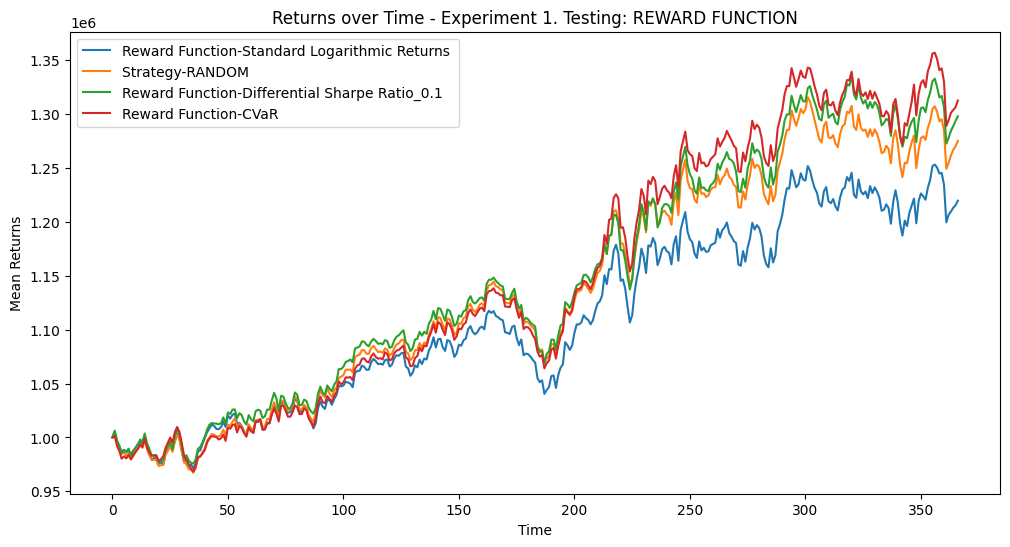

C:\Users\bluem\AppData\Local\Temp\ipykernel_113224\2909671760.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


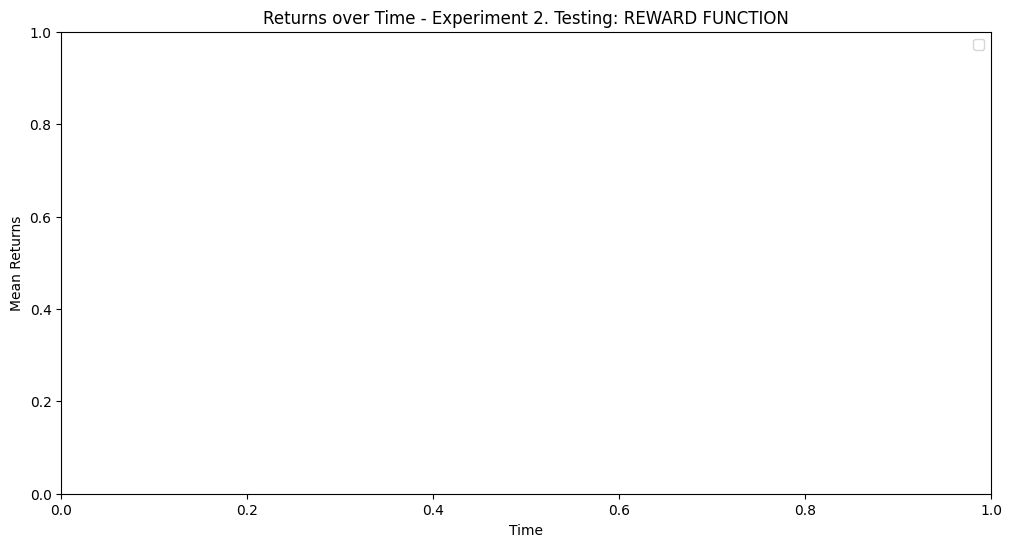

Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.6,25.73,43.7172,644.837,0.0454,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.84,21.01,50.3233,323.525,0.0242,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.11,24.44,35.9726,385.416,0.0281,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.2,22.17,41.071,442.551,0.0317,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.47,28.1,40.6328,586.735,0.0371,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.81,27.29,29.0633,350.111,0.0249,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-30.1,6.24,51.141,-964.815,-0.0881,1047


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.02,12.41,53.4234,273.885,0.023,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.95,29.9,51.5895,763.728,0.0507,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.39,26.77,38.0473,557.176,0.038,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.39,6.95,46.486,65.2105,0.0055,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.03,17.66,48.6881,438.102,0.0331,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-5,6.1,43.2445,-136.6,-0.0116,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.23,34.12,33.8832,907.891,0.0681,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.56,30.14,30.628,507.107,0.0348,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31,31.15,34.9172,846.969,0.0561,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.7,8.89,52.0914,183.01,0.0149,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-6.52,12.89,58.6895,-178.011,-0.0142,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.77,34.25,54.0416,895.407,0.0593,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.41,24.68,28.5421,256.981,0.019,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.95,12.88,50.9167,80.6886,0.0069,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.55,21.26,37.1647,179.04,0.0126,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.68,15.78,49.1131,373.888,0.0291,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
3.16,15.66,44.2617,86.3985,0.0067,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.01,11.45,49.9513,246.282,0.0177,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.48,25.35,45.5728,614.256,0.0439,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
42.81,46.19,47.9979,1169.66,0.07,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
4.1,15.4,44.1034,112.021,0.0088,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.66,12.18,43.6873,264.07,0.0188,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.32,35.69,40.4857,719.26,0.0493,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.85,25.04,53.3663,187.188,0.0122,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.7,25.15,41.8011,538.324,0.0404,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-4.27,10.29,49.3006,-116.682,-0.0107,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-2.56,6.81,45.5062,-69.8927,-0.0062,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.01,19,41.3124,246.248,0.0191,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.82,8.82,57.5705,77.127,0.0062,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.92,17.95,49.2961,79.8247,0.0069,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-3.65,11.3,54.1064,-99.6644,-0.0083,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-7.13,11.16,43.2552,-194.753,-0.0158,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.22,39.32,39.7696,470.393,0.0303,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.92,25.58,49.1333,353.134,0.0235,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.59,14.57,51.8819,180.068,0.0132,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
8.59,20.7,50.2831,234.817,0.0167,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.78,22.19,39.4409,540.456,0.0385,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.96,23.3,48.7652,299.407,0.0185,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.35,29.36,43.8757,719.87,0.0502,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-1.01,8.38,54.3085,-27.5088,-0.0023,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.36,29,47.2981,447.008,0.0319,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
0.05,3.7,50.6383,1.29326,0.0001,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.79,27.9,41.9791,595.321,0.0416,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.15,22.1,60.8149,359.226,0.0264,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
3.31,9.74,54.3873,90.3923,0.0068,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
52.27,52.32,38.5961,1428.03,0.0809,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-10.21,5.65,48.1694,-278.887,-0.0235,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.43,19.17,37.8097,366.875,0.0269,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-2.71,10.88,51.6054,-74.1167,-0.006,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.78,24.67,47.7287,212.661,0.0134,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-7.22,8.17,48.7809,-197.276,-0.0163,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-1.23,9.19,51.4475,-33.6134,-0.0025,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
5.63,11.96,52.5781,153.901,0.0133,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.56,26.43,30.5424,452.576,0.0315,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
5.49,10.07,53.3629,149.937,0.0113,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.96,41.09,45.3971,1009.96,0.0636,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.96,26.46,38.8356,709.243,0.0517,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.63,6.22,38.9033,71.9635,0.0058,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.44,14.23,46.1956,66.7473,0.0053,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.86,32.63,45.2711,378.669,0.0281,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.86,27.64,43.2425,679.224,0.049,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.13,27.26,33.9966,386.106,0.0269,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.7,19.09,48.4428,292.419,0.0219,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.07,34.53,48.6511,766.807,0.0432,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-11.08,4.94,48.0327,-302.763,-0.0248,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-14.72,0.76,54.4791,-402.287,-0.0352,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.68,14.13,49.7266,73.3566,0.0061,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
15.81,19.03,34.7258,432.09,0.0331,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.42,21.02,48.2077,557.936,0.0412,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.29,29.37,53.4072,363.222,0.0258,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
15.58,18.3,41.3333,425.674,0.0324,1101


Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.83,20.34,41.3836,350.629,0.028,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.35,23.75,46.8565,446.776,0.0324,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
8.18,23.25,40.8512,223.589,0.0163,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.82,28.26,47.6465,705.355,0.0517,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.15,21.33,45.1898,249.899,0.0183,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-4.48,5.46,43.6361,-122.468,-0.0102,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.44,34.86,37.4529,285.157,0.0169,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.52,27.51,44.3385,670.023,0.0471,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-11.54,14.6,53.8443,-315.398,-0.0246,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.71,16.12,44.9492,183.38,0.0141,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.2,30.82,40.0536,606.445,0.041,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.38,13.5,53.0569,65.1007,0.0051,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
41.99,46.19,38.0771,1147.28,0.0728,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.81,23.27,36.9952,268.137,0.02,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.46,15.75,42.3839,340.445,0.025,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.2,27.01,43.3763,606.43,0.0431,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.01,27.26,45.437,601.269,0.0387,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-0.67,12.49,41.2226,-18.3289,-0.0015,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.9,14.77,52.5712,215.885,0.0162,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.56,29.73,45.4584,780.291,0.0568,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-11.78,-0.09,48.6797,-321.799,-0.0257,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-2.25,9.81,41.1477,-61.5282,-0.0051,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.6,19.13,40.0967,453.435,0.0327,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.62,23.57,50.0041,563.324,0.0394,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.88,21.2,40.5595,488.399,0.0328,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.01,28.07,39.3683,464.832,0.0337,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-16,7.21,42.9963,-437.199,-0.0368,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.74,20.6,45.2743,539.464,0.0396,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.53,19.36,32.4108,178.325,0.0132,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.27,25.44,34.5737,362.556,0.0274,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.75,17,51.0803,375.78,0.0286,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.67,21.72,49.5317,537.372,0.0403,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
0.01,2.63,44.7205,0.221686,0,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.99,21.91,46.7556,81.8118,0.0063,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.77,19.27,50.7098,212.189,0.0138,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
8.9,14.02,43.5743,243.223,0.0196,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.52,13.03,49.3422,68.9357,0.005,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.07,43.29,41.6553,657.658,0.04,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-8.92,2.89,58.1826,-243.723,-0.0179,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.35,25.13,39.0566,200.773,0.0147,1101


Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
3.9,11.49,51.3862,106.677,0.009,1101


Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.63,29.59,44.5319,727.515,0.0544,1101


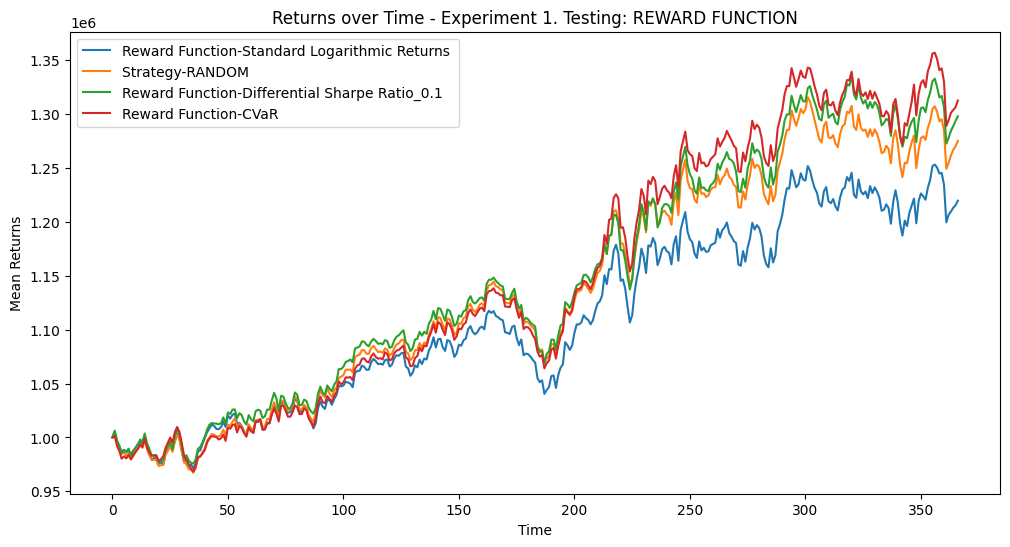

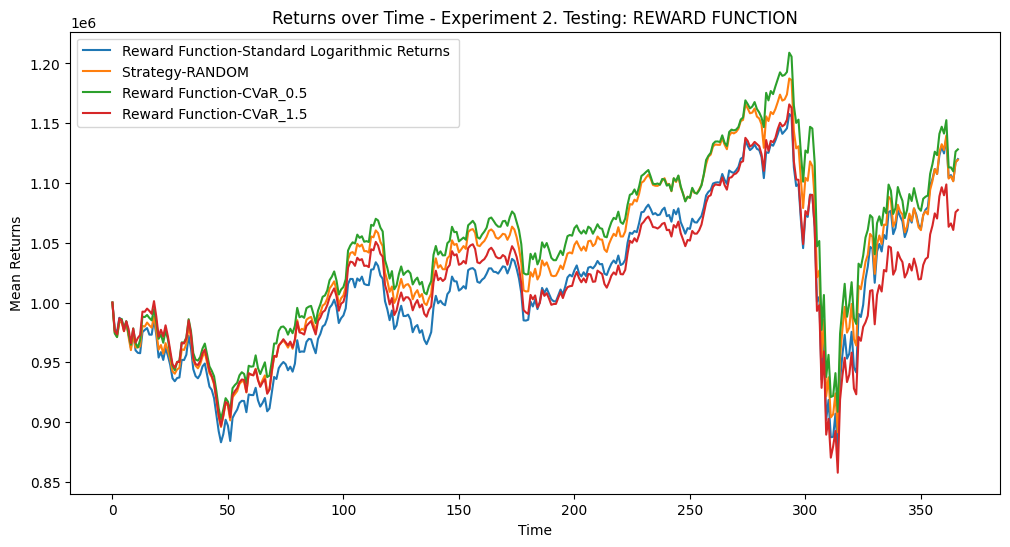

MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
9.897,19.133,46.3871,0,0.016515,1098.3,0.778452


MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.9412,20.5077,44.7896,0,0.0233383,1101,0.184905


MEAN RESULTS FOR: Reward Function-CVaR_0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.8165,22.3385,45.8141,0,0.02262,1101,0.694517


MEAN RESULTS FOR: Reward Function-CVaR_1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
7.7525,18.0975,45.3013,0,0.013765,1101,0.664464


In [ ]:
# To test:
# Exp 1:
# RF: RiskAversion = 0.25, DSR = 0.1. LogRet
# Output Size = 256
# Frequency = 36
# Envs = 0
# LR = 5e-4

# Exp 2:
# RF: RiskAversion = 0.5, 1.5, CVaR, LogRet
# Output Size = 1024
# Frequency = 36
# Envs = 0
# LR = 3e-4

REPEATS = 20

# Experiment 1
EXP_1_CONFIG = {"Reward" : ["Standard Logarithmic Returns", "Differential Sharpe Ratio_0.1", "CVaR"],
                "LSTM Output Size" : 256, 
                "Frequency" : 36,
                "Environments" : 0,
                "Learning Rate" : 5e-4,
                }
EXP_2_CONFIG = {"Reward" : ["Standard Logarithmic Returns", "CVaR_0.5", "CVaR_1.5"],
                "LSTM Output Size" : 1024, 
                "Frequency" : 36,
                "Environments" : 0,
                "Learning Rate" : 3e-4,
                }

def runFinal():
    #terrible code forgive me
    global allResults 
    allResults = defaultdict(list)
    # Configuration 1
    print("=" * 50)
    TESTING["REWARD FUNCTION"] = True
    for r in EXP_1_CONFIG["Reward"]:
        trainingLoop(
        riskAversion=(0.25 if r == "CVaR" else 0),
        rewardFunction=r,
        freq=EXP_1_CONFIG["Frequency"],
        parr=EXP_1_CONFIG["Environments"],
        lstmOutputSize=EXP_1_CONFIG["LSTM Output Size"],
        lr=EXP_1_CONFIG["Learning Rate"],
        expers=(0, 1),
        conf = "Reward Function-" + r + " | " + "Strategy-PPOLSTM" + " | " + "Experiment 1",
    )
    plotPerformance("REWARD FUNCTION", "SecondLast")
    TESTING["REWARD FUNCTION"] = False
    print("=" * 50)

    allResults = defaultdict(list)
    # Configuration 2
    print("=" * 50)
    TESTING["REWARD FUNCTION"] = True
    for r in EXP_2_CONFIG["Reward"]:
        trainingLoop(
        riskAversion=(float(r.split("_")[1]) if r.split("_")[0] == "CVaR" else 0),
        rewardFunction=r.split("_")[0],
        freq=EXP_2_CONFIG["Frequency"],
        parr=EXP_2_CONFIG["Environments"],
        lstmOutputSize=EXP_2_CONFIG["LSTM Output Size"],
        lr=EXP_2_CONFIG["Learning Rate"],
        expers=(1, 2),
        conf = "Reward Function-" + r + " | " + "Strategy-PPOLSTM" + " | " + "Experiment 2",
    )
    plotPerformance("REWARD FUNCTION", "ThirdLast")
    TESTING["REWARD FUNCTION"] = False
    print("=" * 50)
    
    tabulateResults()

RUN_FINAL = True
if RUN_FINAL:
    runFinal()
